In [1]:
import os
import numpy as np
import tensorflow as tf
#import data as d
#import model
import time
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader import data,wb
import matplotlib.pyplot as plt

In [8]:
class StockData():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            indexPath : 종목시장의 인덱스 주 csv파일의 경로.
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈. 10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,indexPath,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize):        
               
        if(train_test_rate<=0 or train_test_rate>=1):
            raise ValueError('train_test_rate should be between 0 and 1')        
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath      
        self.indexPath=indexPath    
        self.batchSize=batchSize
        self.date_duration=40560
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))

        self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}
    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option is not 'training' and option is not 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')

        if(option is 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])             
        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,15,self.T,1))
        xn=np.reshape(xn,(-1,15,self.T,1))
        xi=np.reshape(xi,(-1,self.T,1))
        target=np.reshape(target,(-1,1))

        print("data1 : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)        
        dataframe = pd.DataFrame([])
        

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python')
            if(len(data)>=self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data['open']

                dataframe=dataframe.append(data,ignore_index=True)
        dataT=np.array(dataframe).T
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataT=dataT.T
        dataframe=pd.DataFrame(dataT)
        dataframe=dataframe.transpose()
        print('StockPrice shape: ',dataframe.shape)
        return dataframe
    
    def loadIndex(self):
        data=pd.read_csv(self.indexPath,engine='python')
        data=data[-self.date_duration-1:-1]        
        data=data.reset_index()
        data=data.fillna(method='ffill')

        data=np.array(data['Open'])
        data=np.reshape(data,(-1,1))

        data=self.indexScaler.fit_transform(data)

        data=pd.DataFrame(np.squeeze(data))        

        print('IndexPrice shape: ',data.shape)
        return data 


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in range(maxday,len(self.stockPrice)):
            print('making dataset progress : {}/{}'.format(i,len(self.stockPrice)),end='\r')
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexPrice.loc[i-self.T:i-1]

            for targetNum in priceSet.columns:
                target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[targetNum].T),(15,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[targetNum].T),(15,self.T,1))
                index_history=np.reshape(np.array(indexSet),(self.T,1))
                target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                            })
        print('making dataset progress : finished\t')
        
        return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            posSet.columns=range(self.P)
            negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

            
"""testLine
kospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)
print(np.shape(kospi.trainSet))
print(np.shape(kospi.testSet))
"""


"testLine\nkospi = StockData('StockChart/SAMPLE','StockChart/KOSPI.csv',20,50,10,10,0.7)\nprint(np.shape(kospi.trainSet))\nprint(np.shape(kospi.testSet))\n"

In [4]:

rnn=tf.compat.v1.nn.rnn_cell
class base_LSTMCell(rnn.BasicLSTMCell):
    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            concat = tf.layers.dense(tf.concat([inputs, h],axis=1), 4 * self._num_units)

            # i = input_gate, j = new_input, f = forget_gate, o = output_gate
            i, j, f, o = tf.split(concat, 4, 1)

            new_c = (c * tf.sigmoid(f + self._forget_bias) + tf.sigmoid(i) *
                    self._activation(j))
            new_h = self._activation(new_c) * tf.sigmoid(o)

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state

class MI_LSTMCell(rnn.BasicLSTMCell):
    """
    Multi-Input LSTM proposed in the paper, Stock Price Prediction Using Attention-based Multi-Input LSTM.
    """
    def __init__(self,
               num_units,
               num_inputs,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs):
        """
        Initialize the basic LSTM cell.
        args:
            num_inputs: MI-LSTM의 입력의 개수. 
                이 파라미터에 따라 입력 게이트의 어텐션 레이어를 설정.
                최소 1개이상.
                1개일 경우, 어텐션 레이어를 제외하고 기본 LSTM과 동일.
        """        
        super(MI_LSTMCell,self).__init__(num_units,
               forget_bias=1.0,
               state_is_tuple=True,
               activation=None,
               reuse=None,
               name=None,
               dtype=None,
               **kwargs)
        
        if(type(num_inputs) is not int):
            raise ValueError("num_inputs should be integer")
        if(num_inputs < 1):
            raise ValueError("num_inputs should not be less than 0")
        self.num_inputs = num_inputs
        self.alpha_weight=self.add_variable('alpha_weight',shape=[self._num_units,self._num_units])
        self.alpha_bias=[]
        for i in range(self.num_inputs):
            self.alpha_bias.append(self.add_variable('alpha_bias'+str(i),shape=[1],initializer=tf.zeros_initializer()))

    def __call__(self,inputs,state,scope=None):
        """Long short-term memory cell (LSTM)."""
        with tf.compat.v1.variable_scope(scope or type(self).__name__):  # "BasicLSTMCell"
        # Parameters of gates are concatenated into one multiply for efficiency.
            if self._state_is_tuple:
                c, h = state
            else:
                c, h = tf.split(1, 2, state)
            inputs_list = tf.split(inputs,self.num_inputs,1)
            concat = tf.compat.v1.layers.dense(tf.concat([inputs_list[0], h],axis=1), (3+self.num_inputs) * self._num_units)
                                 
            # 0 = forget_gate, 1 = output_gate, 2= main_new_input, 3 = main_input_gate, 4~ = input_gate_for_auxiliary
            main_list = tf.split(concat, 3+self.num_inputs, 1)
                        
            #new_input_gate= list of all new_input.
            new_input_gate=[tf.tanh(main_list[2])]
            #linear layer for auxiliary inputs.
            for i in range(1,self.num_inputs):
                new_input_gate.append(tf.compat.v1.layers.dense(tf.concat([inputs_list[i], h],axis=1),self._num_units,activation=tf.tanh))

            #making list of l. l = sigmoid(input_gate) * tanh(new_input)
            new_l=[]
            for i,new_input in enumerate(new_input_gate,3):
                new_l.append(tf.sigmoid(main_list[i]) * new_input)


            #making list of u.            
            u=[]
            for i,l in enumerate(new_l):
                #temp = transpos(l) X W X Cell_State.
                temp1=tf.matmul(l,self.alpha_weight)
                temp1=tf.expand_dims(temp1,1)
                temp2=tf.matmul(temp1,tf.expand_dims(c,2))
                u.append(tf.tanh(tf.squeeze(temp2+self.alpha_bias[i],axis=2)))

            #making list of alpha.
            alpha=tf.nn.softmax(u,axis=0)

            #making L.
            L=[]
            for i,l in enumerate(new_l):
                L.append(alpha[i]*l)
            L=tf.reduce_sum(L,axis=0)


            #new state = c(t-1) * f + L. new h = tanh(c) + sigmoid(o)
            new_c = (c * tf.sigmoid(main_list[0] + self._forget_bias)+L)
            new_h = self._activation(new_c) * tf.sigmoid(main_list[1])

            if self._state_is_tuple:
                new_state = rnn.LSTMStateTuple(new_c, new_h)
            else:
                new_state = tf.concat(1, [new_c, new_h])
        return new_h, new_state


class Attention_Layer():
    """
    어텐션 레이어.
    (None, TimeWindow, hidden_unit_size) shape의 LSTM 출력을 입력으로 받아 (None, 1, hidden_unit_size)의 텐서 출력.
    
    """
    def __init__(
        self,
        timewindow_size,
        input_hidden_unit_size,
        attention_size=None):
        """
        Setting parameter for attention layer.
        args:
            timewindow_size = time window size of previous lstm layer.
            input_hidden_unit_size = hidden unit number of previous lstm layer.
            attention_size = size of this attention. 
                default = input_hidden_unit_size.
        """
        if(attention_size is None):
            attention_size=input_hidden_unit_size
        self.o_size=attention_size
        self.h_size=input_hidden_unit_size
        self.t_size=timewindow_size

        self.beta_weight=tf.Variable(tf.random.normal([self.h_size,self.o_size]), name='beta_weight')
        self.beta_bias=tf.Variable(tf.zeros([self.o_size]),name='beta_bias')

        self.v=tf.Variable(tf.random.normal([self.o_size,1]),name='beta_v')

    def __call__(self,inputs):
        """
        producing output with actual inputs.
        shape of output will be (batch_size, 1, input_hidden_unit_size).
        """
        #temp = tanh(Y X W + b) ->shape of result = (-1, self.o_size)
        temp=tf.matmul(tf.reshape(inputs,[-1,self.h_size]),self.beta_weight)
         
        temp=tf.tanh(temp+self.beta_bias)
        
            
        #j=temp X v
        j=tf.reshape(tf.matmul(temp,self.v),[-1,self.t_size,1])

        beta=tf.nn.softmax(j)
        
        

        output=beta*inputs
        return output



In [5]:
class Model():
    """
    모든 예측모델들의 기본 클래스
    """
    def __init__(self,sess,name,windowsize,Pos,Neg):
        self.sess=sess
        self.name=name
        self.T=windowsize
        self.P=Pos
        self.N=Neg

        
        self._build_net()

    def _build_net(self):
        pass

class LSTM_Model(Model):
    """
    Basic LSTM list for test.
    """
    def _build_net(self):
        self.Y=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Xp=tf.compat.v1.placeholder(tf.float32,[None,self.P,self.T,1])
        self.Xn=tf.compat.v1.placeholder(tf.float32,[None,self.N,self.T,1])
        self.Xi=tf.compat.v1.placeholder(tf.float32,[None,self.T,1])
        self.Target=tf.compat.v1.placeholder(tf.float32,[None,1])


        Xps=tf.split(self.Xp,self.P,1)
        Xns=tf.split(self.Xn,self.N,1)
        Xp_list=[]
        Xn_list=[]

    
        LSTM=tf.compat.v1.nn.rnn_cell.LSTMCell(64,name='lstm1')
        
        Y_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Y,dtype=tf.float32)
        Xi_1,_=tf.compat.v1.nn.dynamic_rnn(LSTM,self.Xi,dtype=tf.float32)
        for i in range(len(Xps)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xps[i],axis=1),dtype=tf.float32)
            Xp_list.append(o)
        for i in range(len(Xns)):
            o,_=tf.compat.v1.nn.dynamic_rnn(LSTM,tf.squeeze(Xns[i],axis=1),dtype=tf.float32)
            Xn_list.append(o)
        Xp_1=tf.reduce_mean(Xp_list,0)
        Xn_1=tf.reduce_mean(Xn_list,0)

        result=tf.concat([Y_1,Xp_1,Xn_1,Xi_1],axis=2)
       

        #MI-LSTM
        LSTM2=MI_LSTMCell(64,4,name='lstm2')
       
        Y_2,_ =tf.compat.v1.nn.dynamic_rnn(LSTM2,result,dtype=tf.float32)
       

        #Attention_Layer
        attention_layer=Attention_Layer(self.T,64)
        
        Y_3=attention_layer(Y_2)
        

        #Non-linear units for producing final prediction.
        R_1=tf.compat.v1.layers.dense(tf.compat.v1.layers.flatten(Y_3),64,tf.nn.relu)
        
        R_2=tf.compat.v1.layers.dense(R_1,64,tf.nn.relu)
        
        R_3=tf.compat.v1.layers.dense(R_2,64,tf.nn.relu)
        
        R_4=tf.compat.v1.layers.dense(R_3,64,tf.nn.relu)
        
        R_5=tf.compat.v1.layers.dense(R_4,64,tf.nn.relu)
        
        R_6=tf.compat.v1.layers.dense(R_5,1)
       
        self.out=R_6
        
        self.cost=tf.compat.v1.losses.mean_squared_error(labels=self.Target,predictions=self.out)
        self.optimizer=tf.compat.v1.train.AdamOptimizer(0.001).minimize(self.cost)

    def outputs(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.out,feed_dict=fd)

    def training(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run([self.cost,self.optimizer],feed_dict=fd)

    def returnCost(self,y,xp,xn,xi,target):
        fd={self.Y:y,self.Xp:xp,self.Xn:xn,self.Xi:xi,self.Target:target}
        return self.sess.run(self.cost,feed_dict=fd)
        

IndexPrice shape:  (40559, 1)
StockPrice shape:  (40559, 81)
making dataset progress : finished	59

#training#
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (229

data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.5367233089373258
evalution_cost :  44.2196961498812
epoch : 16, t_cost : 0.000120, e_cost : 0.023019, elapsed time : 1726.73sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.5245157775070766
evalution_cost :  44.00606236856402
epoch : 17, t_cost : 0.000117, e_cost : 0.022908, elapsed time : 1751.20sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.5187768146388407
evalution_cost :  42.91693318304715
epoch : 18, t_cost : 0.000116, e_cost : 0.022341, elapsed time 

data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.42418943252778263
evalution_cost :  29.694326584003647
epoch : 40, t_cost : 0.000095, e_cost : 0.015458, elapsed time : 1722.83sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.42233177828165935
evalution_cost :  29.23039497722857
epoch : 41, t_cost : 0.000094, e_cost : 0.015216, elapsed time : 1676.16sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.4204171353885613
evalution_cost :  29.47496638168377
epoch : 42, t_cost : 0.000094, e_cost : 0.015344, elapsed time : 1679.40sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16,

traning_cost :  0.3798909774304775
evalution_cost :  29.11631612596102
epoch : 64, t_cost : 0.000085, e_cost : 0.015157, elapsed time : 1674.53sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.3829107412293524
evalution_cost :  28.910586957375926
epoch : 65, t_cost : 0.000085, e_cost : 0.015050, elapsed time : 1676.76sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.3812884923290767
evalution_cost :  29.828040192223853
epoch : 66, t_cost : 0.000085, e_cost : 0.015527, elapsed time : 1677.71sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16,

data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.35292346552796516
evalution_cost :  33.361369514126636
epoch : 89, t_cost : 0.000079, e_cost : 0.017367, elapsed time : 1570.40sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.35211294658301995
evalution_cost :  49.82646568646305
epoch : 90, t_cost : 0.000079, e_cost : 0.025938, elapsed time : 1566.50sec
data1 :  (2295726, 16, 1) (2295726, 15, 16, 1) (2295726, 15, 16, 1) (2295726, 16, 1) (2295726, 1)
data1 :  (983883, 16, 1) (983883, 15, 16, 1) (983883, 15, 16, 1) (983883, 16, 1) (983883, 1)
traning_cost :  0.3545539656352048
evalution_cost :  30.199678121534816
epoch : 91, t_cost : 0.000079, e_cost : 0.015721, elapsed 

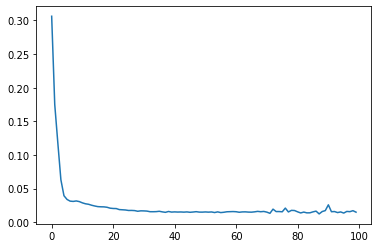

In [9]:

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

#parameter list
sess=tf.compat.v1.Session()
name='lstm'
timesize=16
timesize_for_calc_correlation=70
positive_correlation_stock_num=15
negative_correlation_sotck_num=15
train_test_rate=0.7
batch_size=512
#
kospi=StockData(
    'NASDAQ/sample',
    'NASDAQ/NDX.csv',
    timesize,timesize_for_calc_correlation,
    positive_correlation_stock_num,
    negative_correlation_sotck_num,
    train_test_rate,
    batch_size)

print('\n#training#')
lstmModel=LSTM_Model(
    sess,
    name,
    timesize,
    positive_correlation_stock_num,
    negative_correlation_sotck_num
    )



sess.run(tf.compat.v1.global_variables_initializer())
result_dic={}
evalution_costplt=[]
for i in range(100):
    #epoch start
    start_time = time.time()
    training_cost=0
    evalution_cost=0

    #training batch
    for batch in kospi.getBatch('training'):
        c,_=lstmModel.training(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        training_cost+=c
       
    #evaluation batch
    for batch in kospi.getBatch('evaluation'):
        c=lstmModel.returnCost(batch['y'],batch['xp'],batch['xn'],batch['xi'],batch['target'])
        evalution_cost+=c

    print("traning_cost : " , training_cost)
    print("evalution_cost : " , evalution_cost)
   
    #epoch end
    elapsed_time = time.time()-start_time
    training_cost=training_cost/kospi.batchNum['training']
    evalution_cost=evalution_cost/kospi.batchNum['evaluation']
    result_dic[i]=[training_cost,evalution_cost]
    evalution_costplt.append(evalution_cost)

    print('epoch : {}, t_cost : {:0.6f}, e_cost : {:0.6f}, elapsed time : {:0.2f}sec'.format(
        i,training_cost,evalution_cost,elapsed_time))
#

sorted_result=sorted(result_dic,key=lambda k:result_dic[k][1])
bestEpoch=sorted_result[0]
print('\n#Best result at epoch {}'.format(bestEpoch))
print('t_cost : {:0.6f}, e_cost : {:0.6f}'.format(result_dic[bestEpoch][0],result_dic[bestEpoch][1]))
print(plt.plot(evalution_costplt))
print(np.mean(evalution_costplt))